In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit, train_test_split as split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


In [24]:
#read file
df = pd.read_csv('global-data-on-sustainable-energy (1).csv')
df.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,...,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953


In [25]:
#check for duplicates
num_duplicates = df.duplicated().sum()
print("Number of Duplicate Rows:", num_duplicates)

Number of Duplicate Rows: 0


In [26]:
# Fixing inconsistency in column names and converting 'Density' columns to float
df = df.rename(columns={col: 'Density' for col in df.columns if 'Density' in col})
df['Density'] = df['Density'].astype(str).str.replace(',', '').astype(float)

In [27]:
#check for missing values
df.isna().sum()

Entity                                                                 0
Year                                                                   0
Access to electricity (% of population)                               10
Access to clean fuels for cooking                                    169
Renewable-electricity-generating-capacity-per-capita                 931
Financial flows to developing countries (US $)                      2089
Renewable energy share in the total final energy consumption (%)     194
Electricity from fossil fuels (TWh)                                   21
Electricity from nuclear (TWh)                                       126
Electricity from renewables (TWh)                                     21
Low-carbon electricity (% electricity)                                42
Primary energy consumption per capita (kWh/person)                     0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          207
Value_co2_emissions_kt_by_country                  

In [28]:
# remove rows with too many missing values
df = df.drop(columns = ['Financial flows to developing countries (US $)'])
df = df.drop(columns = ['Renewables (% equivalent primary energy)'])
df = df.drop(columns = ['Renewable-electricity-generating-capacity-per-capita'])

# drop rows where critical columns are missing
df = df.dropna(subset=['Latitude', 'Longitude', 'Land Area(Km2)', 'Density'])

# impute missing values based on Entity
columns_to_fill = [
    'Access to clean fuels for cooking', 
    'Renewable energy share in the total final energy consumption (%)', 
    'Electricity from nuclear (TWh)', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 
    'Value_co2_emissions_kt_by_country', 'gdp_growth','gdp_per_capita',
    'Electricity from fossil fuels (TWh)', 'Electricity from renewables (TWh)', 
    'Low-carbon electricity (% electricity)', 'Access to electricity (% of population)'
]

for col in columns_to_fill:
    # impute mean by Entity
    df[col] = df.groupby('Entity')[col].transform(lambda x: x.fillna(x.mean()))
    
    # impute global mean as fallback
    global_mean = df[col].mean()
    df[col] = df[col].fillna(global_mean)

In [29]:
# encode categorical variables (entity)
label_encoder = LabelEncoder()
df['Entity_encoded'] = label_encoder.fit_transform(df['Entity'])

In [30]:
#sort values by Year and Entity
df = df.sort_values(by=['Year', 'Entity']).reset_index(drop=True)

# Define features and target variable
X = df.drop(columns = ['Primary energy consumption per capita (kWh/person)','Entity'])
y = df['Primary energy consumption per capita (kWh/person)']

In [31]:
#feature selection using model-based approach
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median')
features = selector.fit_transform(X, y)
selected = selector.get_support()

selected_features = X.columns[selected].tolist()

#print selected features with numbering
print("\n--- Model-based Selection ---")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")
    

X_selected = X[selected_features]
X_selected.shape, y.shape


--- Model-based Selection ---
1. Access to clean fuels for cooking
2. Renewable energy share in the total final energy consumption (%)
3. Energy intensity level of primary energy (MJ/$2017 PPP GDP)
4. gdp_per_capita
5. Density
6. Land Area(Km2)
7. Latitude
8. Longitude
9. Entity_encoded


((3648, 9), (3648,))

In [32]:
train = df.loc[df.Year < 2017]
test = df.loc[df.Year >= 2017]

Target = 'Primary energy consumption per capita (kWh/person)'

X_train = train[X_selected.columns]
y_train = train[Target]

X_test = test[X_selected.columns]
y_test = test[Target]

*Part 2: Model Training*  

In [33]:
final_model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Final Model R²: {r2:.4f}')
print(f'Final Model MAE: {mae:.4f}')

Final Model R²: 0.9656
Final Model MAE: 3119.3297


In [34]:
print(df.columns)

Index(['Entity', 'Year', 'Access to electricity (% of population)',
       'Access to clean fuels for cooking',
       'Renewable energy share in the total final energy consumption (%)',
       'Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)',
       'Electricity from renewables (TWh)',
       'Low-carbon electricity (% electricity)',
       'Primary energy consumption per capita (kWh/person)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'Value_co2_emissions_kt_by_country', 'gdp_growth', 'gdp_per_capita',
       'Density', 'Land Area(Km2)', 'Latitude', 'Longitude', 'Entity_encoded'],
      dtype='object')


In [35]:
results= []
models={}
models['lnr'] =LinearRegression()
models['knn'] =KNeighborsRegressor()
models['rfr'] =RandomForestRegressor()
models['mpr'] =MLPRegressor()
models['gbr'] =GradientBoostingRegressor()
models['dtr'] =DecisionTreeRegressor()
models['rrn'] =Ridge(alpha=10)
models['svr'] =SVR()

In [36]:
kf= KFold(n_splits=5, shuffle=True, random_state=42)

In [37]:
for n in models:
    scores= cross_val_score(models[n], X_selected, y, cv=kf, n_jobs=-1)
    print(f'model: {n} {scores.mean():.3%} +/- {scores.std():.3%}')

model: lnr 64.470% +/- 0.970%
model: knn 94.810% +/- 1.607%
model: rfr 98.375% +/- 0.627%
model: mpr 67.619% +/- 1.616%
model: gbr 96.855% +/- 0.475%
model: dtr 95.731% +/- 1.341%
model: rrn 64.470% +/- 0.969%
model: svr -13.123% +/- 0.953%


In [38]:
scalers ={}
scalers['mms']= MinMaxScaler()
scalers['std']= StandardScaler()
scalers['rbs']= RobustScaler()


In [39]:
results= []
kfs= KFold(n_splits=3, shuffle=True, random_state=42)
for s in scalers:
    X_train_scaled= scalers[s].fit_transform(X_train)
    X_test_scaled= scalers[s].transform(X_test)
    print(f'\t With {s} Scaling: ')
    for n in models:
        scores= cross_val_score(models[n], X_train_scaled, y_train ,cv= kfs, n_jobs=-1)
        print(f'Models: {n}: {scores.mean():.3%} +/- {scores.std():.3%}')
        results.append({
            'Scaler': s, 
            'Model': n, 
            'R2 Score Mean':scores.mean(),
            'R2 Score Std': scores.std()})

	 With mms Scaling: 
Models: lnr: 63.738% +/- 1.868%
Models: knn: 98.018% +/- 0.680%
Models: rfr: 97.333% +/- 0.738%
Models: mpr: -44.982% +/- 0.591%
Models: gbr: 96.267% +/- 0.544%
Models: dtr: 93.773% +/- 1.185%
Models: rrn: 61.304% +/- 2.384%
Models: svr: -13.131% +/- 0.887%
	 With std Scaling: 
Models: lnr: 63.738% +/- 1.868%
Models: knn: 97.517% +/- 0.616%
Models: rfr: 97.504% +/- 0.512%
Models: mpr: -41.754% +/- 0.610%
Models: gbr: 96.308% +/- 0.504%
Models: dtr: 94.009% +/- 0.502%
Models: rrn: 63.743% +/- 1.879%
Models: svr: -13.243% +/- 0.818%
	 With rbs Scaling: 
Models: lnr: 63.738% +/- 1.868%
Models: knn: 97.143% +/- 0.447%
Models: rfr: 97.272% +/- 0.642%
Models: mpr: -32.202% +/- 1.982%
Models: gbr: 96.300% +/- 0.550%
Models: dtr: 93.632% +/- 1.260%
Models: rrn: 63.738% +/- 1.887%
Models: svr: -13.253% +/- 0.891%


In [40]:
result_df= pd.DataFrame(results)

print(result_df)

   Scaler Model  R2 Score Mean  R2 Score Std
0     mms   lnr       0.637378      0.018683
1     mms   knn       0.980177      0.006801
2     mms   rfr       0.973326      0.007378
3     mms   mpr      -0.449822      0.005906
4     mms   gbr       0.962670      0.005440
5     mms   dtr       0.937726      0.011854
6     mms   rrn       0.613038      0.023842
7     mms   svr      -0.131307      0.008871
8     std   lnr       0.637378      0.018683
9     std   knn       0.975170      0.006159
10    std   rfr       0.975038      0.005125
11    std   mpr      -0.417543      0.006100
12    std   gbr       0.963079      0.005036
13    std   dtr       0.940085      0.005017
14    std   rrn       0.637429      0.018786
15    std   svr      -0.132431      0.008184
16    rbs   lnr       0.637378      0.018683
17    rbs   knn       0.971431      0.004473
18    rbs   rfr       0.972723      0.006419
19    rbs   mpr      -0.322021      0.019815
20    rbs   gbr       0.963003      0.005503
21    rbs 

In [41]:
scl= RobustScaler()
Xs_train= scl.fit_transform(X_train)
Xs_test= scl.transform(X_test)

d:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


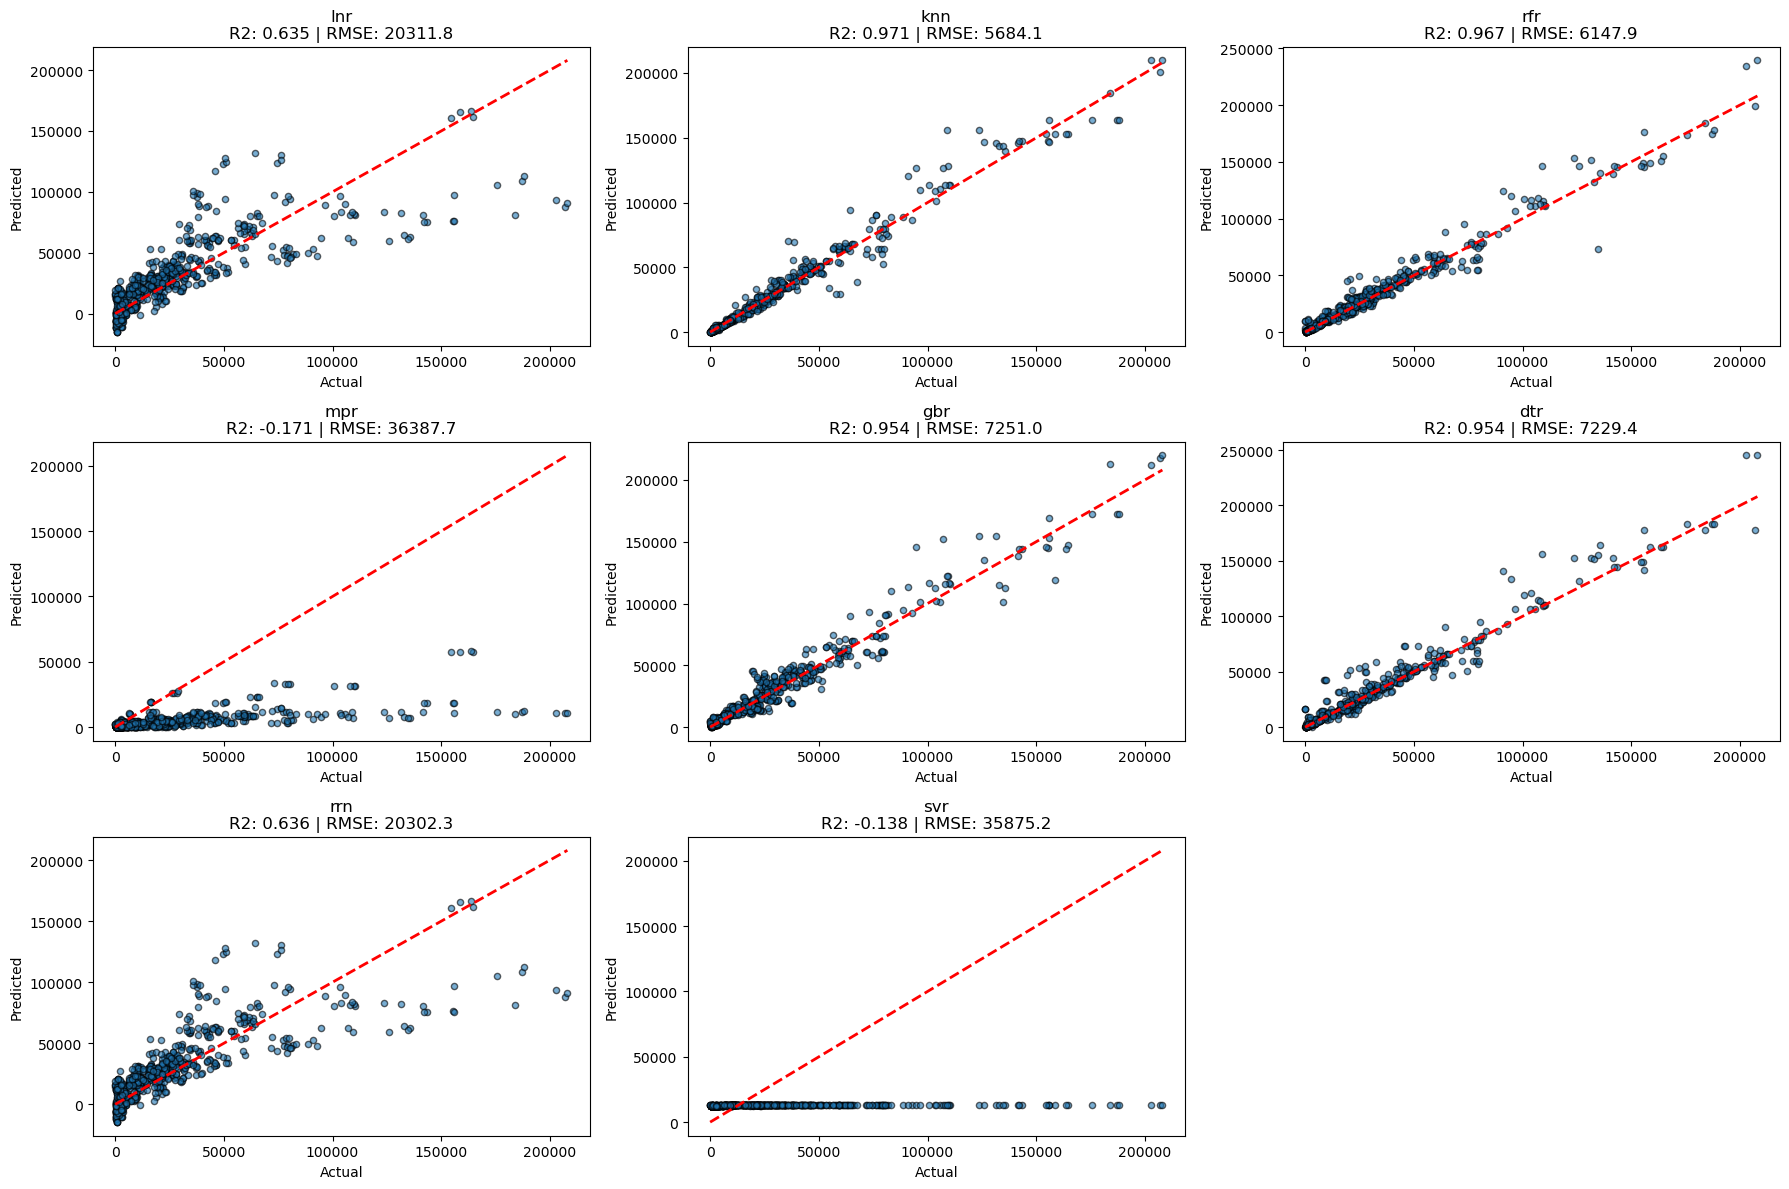

In [42]:
plt.figure(figsize=(18,12))

for i,n in enumerate(models, start=1):
    models[n].fit(X_train_scaled, y_train)
    y_pred= models[n].predict(X_test_scaled)

    r2= r2_score(y_test, y_pred)
    rmse= np.sqrt(mean_squared_error(y_test, y_pred))
    mae= mean_absolute_error(y_test, y_pred)

    plt.subplot(3,3,i)
    plt.scatter(y_test,y_pred, alpha=0.6, edgecolors='k', s=20)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'{n}\nR2: {r2:.3f} | RMSE: {rmse:.1f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

In [43]:
rfr= RandomForestRegressor().fit(X_train, y_train)
print(f'Accuracy: {rfr.score(X_test, y_test):.3f}')

Accuracy: 0.968


In [44]:
from sklearn.model_selection import GridSearchCV
kfp= KFold(n_splits=3, shuffle=True, random_state=42)

best_hyp= {}

hyp_grid = {
    'lnr': {'copy_X': [True, False], 'fit_intercept': [True, False]},
    'knn': {'leaf_size': [5, 10], 'n_neighbors': [20, 50], 'weights': ['uniform', 'distance']},
    'dtr': {'max_depth': [10, 20, None], 'min_samples_split': [2, 5]},
    'rfr': {'n_estimators': [50, 100], 'max_depth': [None, 10]},
    'gbr': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]},
    'mpr': {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['tanh', 'relu']},
    'svr': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}
for n in hyp_grid:
    grid_search= GridSearchCV(
        estimator= models[n],
        param_grid= hyp_grid[n],
        cv= kfp,
        scoring='r2',
        n_jobs= -1
    )

    grid_search.fit(X_train_scaled, y_train)
    best_hyp[n]= grid_search.best_params_

    print(f'{n} Best CV Score: {grid_search.best_score_:.3%}')

models_tuned= {
    'lnr' :LinearRegression(**best_hyp['lnr']),
    'knn' :KNeighborsRegressor(**best_hyp['knn']),
    'rfr' :RandomForestRegressor(**best_hyp['rfr']),
    'mpr' :MLPRegressor(**best_hyp['mpr']),
    'gbr' :GradientBoostingRegressor(**best_hyp['gbr']),
    'dtr' :DecisionTreeRegressor(**best_hyp['dtr']),
    'rrn' :Ridge(alpha=10),
    'svr' :SVR(**best_hyp['svr'])
}


lnr Best CV Score: 63.738%
knn Best CV Score: 95.313%
dtr Best CV Score: 94.528%
rfr Best CV Score: 97.582%
gbr Best CV Score: 96.293%


d:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mpr Best CV Score: -33.433%
svr Best CV Score: 45.040%


In [45]:
final_result= []

for name, model in models_tuned.items():
    model.fit(X_train_scaled, y_train)
    y_pred= model.predict(X_test_scaled)

    r2= r2_score(y_test, y_pred)
    rmse= np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    final_result.append({
        'Model': name,
        'R2 Score': r2,
        'MAE': mae,
        'RMSE': rmse
    })

final_df= pd.DataFrame(final_result)
final_df

d:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,R2 Score,MAE,RMSE
0,lnr,0.635216,12776.515589,20311.840212
1,knn,0.960556,3389.871052,6679.199896
2,rfr,0.968151,3002.633113,6001.746914
3,mpr,-0.127265,20802.419288,35706.258775
4,gbr,0.953536,4411.117956,7249.210316
5,dtr,0.955329,3281.766901,7107.978141
6,rrn,0.635557,12691.598949,20302.336811
7,svr,0.529504,11062.727075,23067.959456


d:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


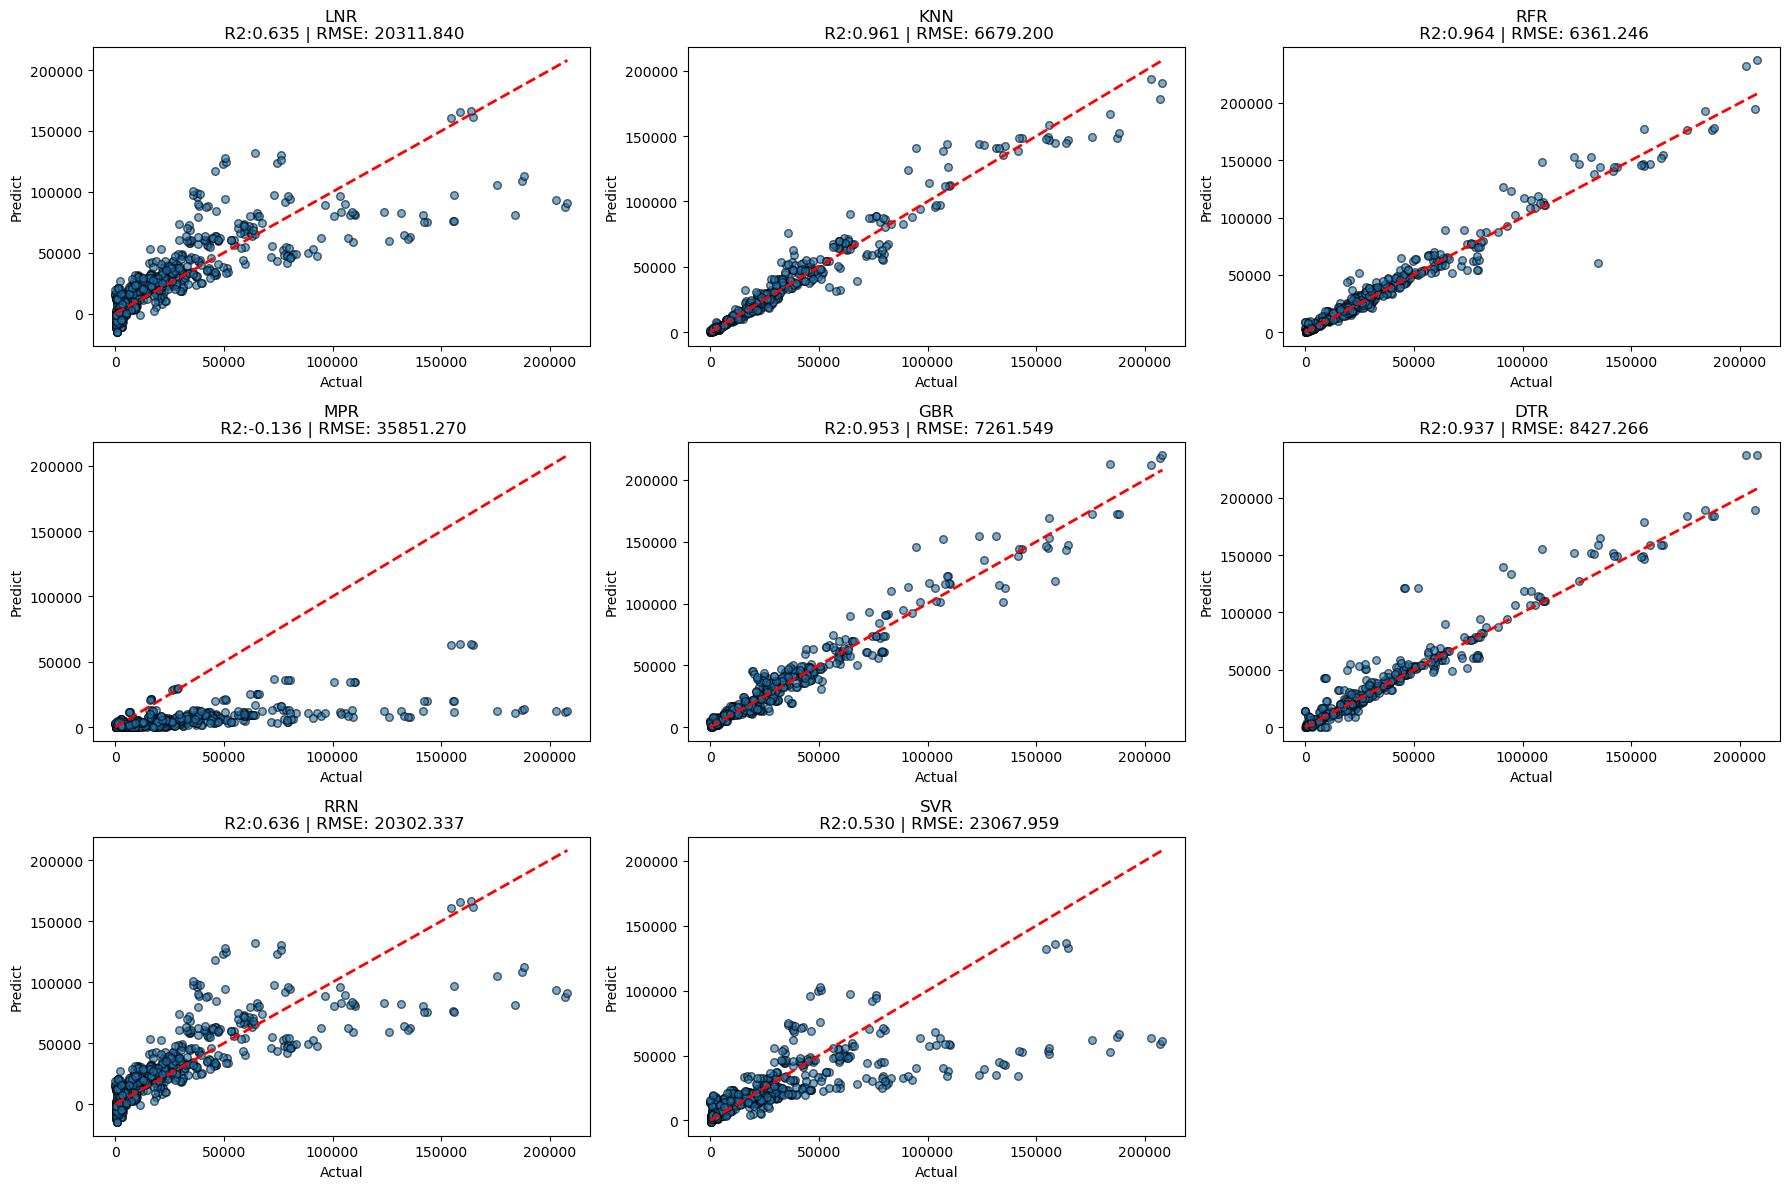

In [46]:
plt.figure(figsize= (18,12))

final_comparison= []

for i, n in enumerate(models_tuned, start=1):
    models_tuned[n].fit(X_train_scaled, y_train)
    y_pred= models_tuned[n].predict(X_test_scaled)

    rmse= np.sqrt(mean_squared_error(y_test, y_pred))
    mae= mean_absolute_error(y_test, y_pred)
    score= models_tuned[n].score(X_test_scaled, y_test)

    final_comparison.append({
        'Model': n,
        'R2': score,
        'RMSE': rmse,
        'MAE': mae
    })

    plt.subplot(3,3,i)
    plt.scatter(y_test, y_pred, alpha= 0.6, edgecolors= (0,0,0), s=30)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predict')
    plt.title(f'{n.upper()}\n R2:{score:.3f} | RMSE: {rmse:.3f}')

plt.tight_layout()
plt.show()